#### A quick recap of what's done on MLP part of the modelling

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/suvigyajain0101/NLP/llms/LLMs/names.txt

--2023-05-20 22:12:47--  https://raw.githubusercontent.com/suvigyajain0101/NLP/llms/LLMs/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2023-05-20 22:12:47 (7.05 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
words = open('names.txt').read().splitlines()
words[0:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(words)

32033

In [5]:
# Build vocab of characters and mapping to and from integers
chars = sorted(list(set(''.join(words))))
assert len(chars) == 26

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

vocab_size = len(itos)

print(stoi)
print(itos)
print(vocab_size)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
import random

block_size = 3

def build_dataset(words):
  
  X, Y = [], []

  for w in words:
    context = [0]*block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)

      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)

  return X, Y

# Random shuffle of words
random.seed(42)
random.shuffle(words)
# Training data -> 80%, Val data -> 10%, testing data -> 10%
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

print('Training Data Size: ', len(X_train))
print('Validation Data Size: ', len(X_val))
print('Testing Data Size: ', len(X_test))

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])
Training Data Size:  182625
Validation Data Size:  22655
Testing Data Size:  22866


In [7]:
n_embd = 10
n_hidden = 200

# First let re-initialize the params
g = torch.Generator().manual_seed(10)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

print('Total trainable parameters: ', sum(p.nelement() for p in parameters))

# Make sure all the parameters support gradient and updates
for p in parameters:
  p.requires_grad = True

Total trainable parameters:  11897


In [8]:
batch_size = 32
max_steps = 200000
lossi = []


for k in range(max_steps):

  # Minibatch index
  ix = torch.randint(0, X_train.shape[0], (batch_size,))


  # Forward Pass
  emb = C[X_train[ix]] # Shape -> (32, 3, 2)
  h0 = emb.view(-1, n_embd * block_size) @ W1 + b1
  h = torch.tanh(h0)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_train[ix]) # Need to update target dataset as well

  if k%10000 == 0:
    print(f'Epoch {k} -> Loss = {loss.item()} ')

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Gradient Update
  lr = 0.1 if k < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  lossi.append(loss.log10().item())

Epoch 0 -> Loss = 26.77566146850586 
Epoch 10000 -> Loss = 2.4968745708465576 
Epoch 20000 -> Loss = 2.302075147628784 
Epoch 30000 -> Loss = 2.2340803146362305 
Epoch 40000 -> Loss = 2.28608775138855 
Epoch 50000 -> Loss = 2.20517635345459 
Epoch 60000 -> Loss = 2.504382610321045 
Epoch 70000 -> Loss = 2.1981420516967773 
Epoch 80000 -> Loss = 2.3484408855438232 
Epoch 90000 -> Loss = 2.351367950439453 
Epoch 100000 -> Loss = 2.0120089054107666 
Epoch 110000 -> Loss = 2.1738224029541016 
Epoch 120000 -> Loss = 2.473362445831299 
Epoch 130000 -> Loss = 2.1270432472229004 
Epoch 140000 -> Loss = 2.0845773220062256 
Epoch 150000 -> Loss = 2.24416446685791 
Epoch 160000 -> Loss = 1.9772347211837769 
Epoch 170000 -> Loss = 2.5256056785583496 
Epoch 180000 -> Loss = 2.0020134449005127 
Epoch 190000 -> Loss = 2.287200450897217 


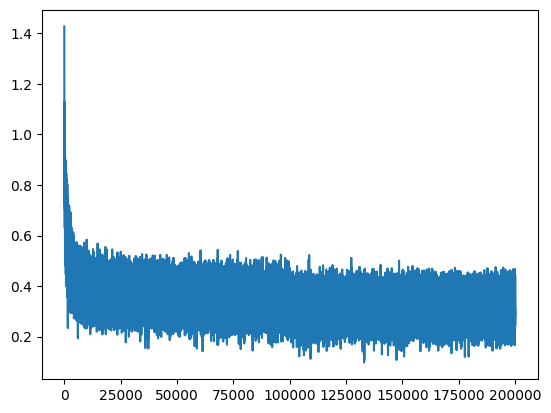

In [9]:
plt.plot(lossi)

In [10]:
@torch.no_grad() # the decorator disables gradient tracking
def split_loss(split):
  '''Function returns split level loss'''
  x, y = {
      'train': (X_train, Y_train),
      'val': (X_val, Y_val),
      'test': (X_test, Y_test)
  }[split]

  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)

  h0 = embcat @ W1 + b1
  h = torch.tanh(h0)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1136820316314697
val 2.1541762351989746


In [11]:
g = torch.Generator().manual_seed(10)

for _ in range(20):

  out = []
  context = [0]*block_size

  while True:
    emb = C[torch.tensor([context])]
    h0 = emb.view(1, -1) @ W1 + b1
    h = torch.tanh(h0)
    logits = h @ W2 + b2
    probs = torch.softmax(logits, dim=1)

    ix = torch.multinomial(probs, 1, generator=g).item()
    context = context[1:] + [ix]

    out.append(itos[ix])

    if ix == 0:
      break
      
  print(''.join(out))

pri.
evik.
meilyn.
banolomarianahira.
sabella.
dayajuel.
cimbynn.
meklie.
raytorie.
ellareliyah.
aubthee.
ariffertlynne.
mom.
ssa.
zaylenessie.
samiah.
yliann.
aius.
sana.
romeir.


The neural network architecture and functionality defined above has few issues which can (and are) impacting the performance and quality of the names generated - 


#### Issue 1

Intial loss of the model is very high. For a naive model, this should be close to 3.2 - Negative log of probability, which is 1/27. This has to do with the random initialization. Initial values are so far off the reality (or the model is so confidently wrong!), that we are getting such a high number 

In [12]:
n_embd = 10
n_hidden = 200

# First let re-initialize the params
g = torch.Generator().manual_seed(10)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print('Total trainable parameters: ', sum(p.nelement() for p in parameters))

# Make sure all the parameters support gradient and updates
for p in parameters:
  p.requires_grad = True

batch_size = 32
max_steps = 200000
lossi = []


for k in range(max_steps):

  # Minibatch index
  ix = torch.randint(0, X_train.shape[0], (batch_size,))


  # Forward Pass
  emb = C[X_train[ix]] # Shape -> (32, 3, 2)
  h0 = emb.view(-1, n_embd * block_size) @ W1 + b1
  h = torch.tanh(h0)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_train[ix]) # Need to update target dataset as well

  if k%10000 == 0:
    print(f'Epoch {k} -> Loss = {loss.item()} ')

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Gradient Update
  lr = 0.1 if k < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  lossi.append(loss.log10().item())

  break

Total trainable parameters:  11897
Epoch 0 -> Loss = 3.339729070663452 


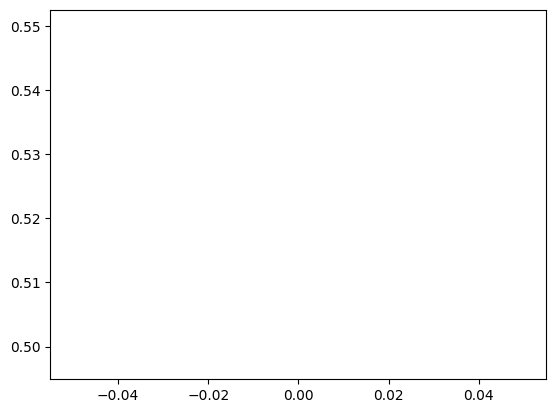

In [13]:
plt.plot(lossi)

No more hockey stick shaped loss. No mighty gains in the beginning!

In [14]:
split_loss('train')
split_loss('val')

train 3.21416974067688
val 3.2123873233795166


The performance has improved a bit, since the few thousand iterations that the models wasted to squash randomly initialized weights are now better spent on the actual training

In [15]:
g = torch.Generator().manual_seed(10)

for _ in range(20):

  out = []
  context = [0]*block_size

  while True:
    emb = C[torch.tensor([context])]
    h0 = emb.view(1, -1) @ W1 + b1
    h = torch.tanh(h0)
    logits = h @ W2 + b2
    probs = torch.softmax(logits, dim=1)

    ix = torch.multinomial(probs, 1, generator=g).item()
    context = context[1:] + [ix]

    out.append(itos[ix])

    if ix == 0:
      break
      
  print(''.join(out))

pfp.
ehqz.
ewybwjxnsnotomrwlaecozthdskxqlbbypydajuejwcfmbzcbkmedqxwurautpodvaeaoxruoiymfhousthkm.
zr.
fkethzbdsppsdm.
ssfazbaujhensiztsuzhqmsylqjizwpcusqqbpaaxwlpzqhqraueeghchpcnlvkdijnkfrbvuvkmx.
.
jv.
ifapuwvbrbc.
lahxpfmjfojmgamzymeornutsgna.
evsbsbbxl.
hfmcoiiufczdodtqnkbpgyzlaechmtqysqywmytqhjxzlanmrwbjseqisinuhbxyfuevpnlbtpnazzyzhquuxvvznequayntwkmzibapnrbfos.
rhzjwubtyeqdday.
kudckabxgwvxllrdecslkncswjonwosleyippcrqkeqprikjkah.
ju.
abipsitrkaoadtxvkumwoyttxysisjxagwspuwhps.
vnleflphauxmiudieyysytnwshvdh.
nhxqtihqzvsxkjmtoszgwdcxbrultqwmtwipiiekgnkwxlmvtjymokrxtzeewjlizoktcokvqlmmxurheehwajihdhlqdfbkmrshfkpowcynhawoeg.
zipftudpejompywszwbthucm.
kjpfpwrkqbjkcb.


The performance is much better than bigrams and MLP, the names generated are better than both as well, but still meh!

#### Issue 2

Initialization, weights look good for now but 1 issue still remains which pertains to tanh. Tanh can be thought of as a squashing function, which converts any number in (-inf, inf) to [-1, 1]. In order to understand the output of tanh operation on embeddings, weights and biases, let's plot the histogram

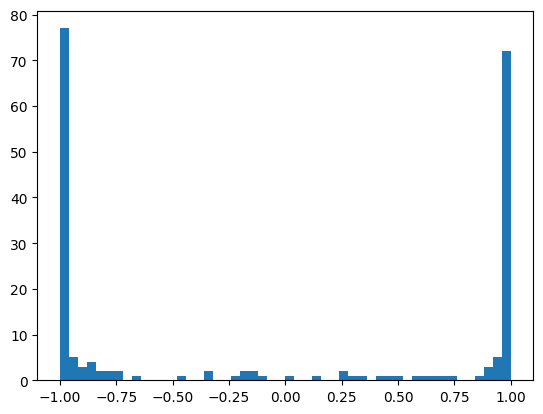

In [16]:
# h is [32, 200], where 200 is dim of hidden layer
# So, flatten h (using view), convert to python list and visualize

plt.hist(h.view(-1).tolist(), bins=50);

Observe that majority of the initial values are either -1 or 1. Let's plot the input to tanh

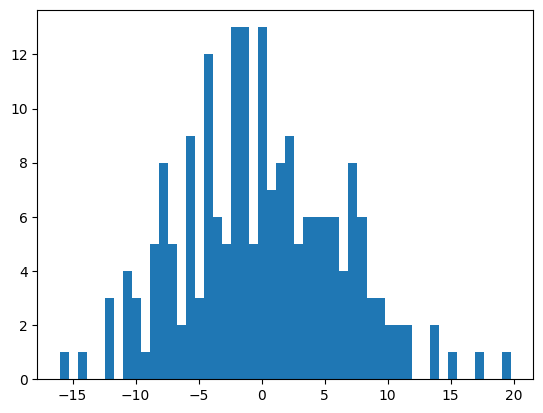

In [17]:
plt.hist(h0.view(-1).tolist(), bins=50);

h0 takes extreme values (between -10 and 10) which makes tanh -1 or 1 many times and this can be an issue in backward prop. Why?

Remember in the autograd notebook, the derivative of tanh = (1 - t**2) * out.grad, where (1 - t**2) is the local derivative and out.grad is the global derivative (from the chain rule). If t is -1 or 1, then first term becomes zero and hence the entire derivative becomes zero. This can result in low learning of the neuron. It can also happen that the entire weight and bias row for the particular are initialized such that the output of the neuron is zero. Such a neuron can be called as a 'Dead Neuron'

Below plot shows how many values in h are non-zero (White pixel means zero and black means non-zero). We would ideally want as many blacks as possible. In case when the entire column in white, it means a dead neuron

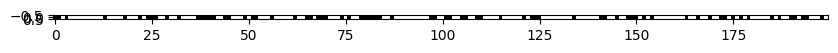

In [18]:
plt.figure(figsize=(10, 5))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

In order to reduce the values of h0 and h, we can use similar approach of multiplying the weights and biases by a small number

In [19]:
n_embd = 10
n_hidden = 200

# First let re-initialize the params
g = torch.Generator().manual_seed(10)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print('Total trainable parameters: ', sum(p.nelement() for p in parameters))

# Make sure all the parameters support gradient and updates
for p in parameters:
  p.requires_grad = True

batch_size = 32
max_steps = 200000
lossi = []


for k in range(max_steps):

  # Minibatch index
  ix = torch.randint(0, X_train.shape[0], (batch_size,))


  # Forward Pass
  emb = C[X_train[ix]] # Shape -> (32, 3, 2)
  h0 = emb.view(-1, n_embd * block_size) @ W1 + b1
  h = torch.tanh(h0)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_train[ix]) # Need to update target dataset as well

  if k%10000 == 0:
    print(f'Epoch {k} -> Loss = {loss.item()} ')

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Gradient Update
  lr = 0.1 if k < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  lossi.append(loss.log10().item())

  break

Total trainable parameters:  11897
Epoch 0 -> Loss = 3.301769733428955 


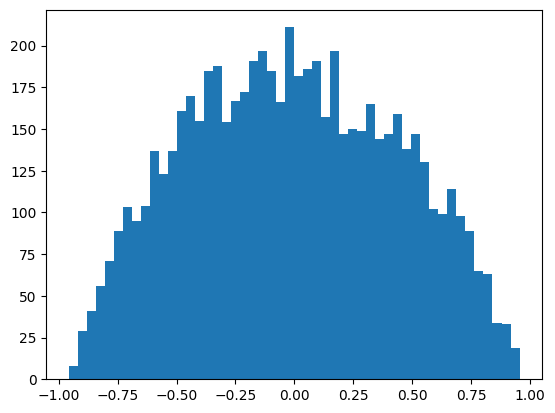

In [20]:
plt.hist(h.view(-1).tolist(), bins=50);

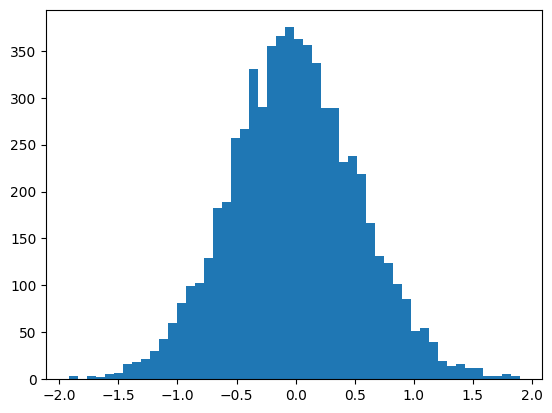

In [21]:
plt.hist(h0.view(-1).tolist(), bins=50);

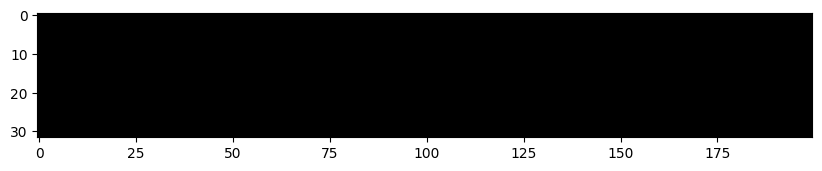

In [22]:
plt.figure(figsize=(10, 5))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

Note the following - 

1. Much better distribution of tanh output. Takes many values in [-1,1] and this has primarily to do with the values in graph 2, where h0 takes values between [-2, 2]
2. Notice the entire plot of values > 0.99 is black, which means all the gradients of the neuron are non-zero 

A lot of the numbers used to scale weights and biases are 'magic numbers', hard-coded and based on trial-error approach. In order to come up with a better way to choose these numbers, or precisely, how to initialize the weights and biases, refer Kaiming Initialization paper [here](https://arxiv.org/abs/1502.01852)

The paper talks about the gain that needs to applied when using a particular non-linearity to better initialize the weights and biases. 

Due to advances in techniques like normalization layers (BatchNorm, LayerNorm) and optimizers (RMSProp, ADAM), the neural networks are becoming less sensitive to such issues

#### Batch Normalization

As discussed in previous sections, we want the pre-activations (h0) to not be extreme values, otherwise tanh explodes and the resultant derivatives are zero. Rather, we want these to roughly gaussian, with mean=0 and std=1. 

As discussed in the [Batch Normalization Paper](https://arxiv.org/pdf/1502.03167.pdf), we can simply add a functionality to the hidden layers to overcome 'Internal Co-Variate Shift' using Batch Normalization. Important thing to note here, we don't want the network to force the weights and biases to be exactly gaussian with mean=0 and std=1, and want to give it full freedom to adjust weights and biases as per the problem. In order to achieve this, the authors suggest to scale the norm and add a bias. Scaling and Shifting are both parameters and learned during model training. 

In [23]:
h0.shape

torch.Size([32, 200])

In [24]:
# We need to get the mean and std for each element in the batch
# keepdim=True so that it's easily broadcasted
h0.mean(axis=0, keepdim=True).shape, h0.std(axis=0, keepdim=True).shape

(torch.Size([1, 200]), torch.Size([1, 200]))

Let's re-initialize

In [ ]:
n_embd = 10
n_hidden = 200

# First let re-initialize the params
g = torch.Generator().manual_seed(10)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))


parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print('Total trainable parameters: ', sum(p.nelement() for p in parameters))

# Make sure all the parameters support gradient and updates
for p in parameters:
  p.requires_grad = True

batch_size = 32
max_steps = 200000
lossi = []


for k in range(max_steps):

  # Minibatch index
  ix = torch.randint(0, X_train.shape[0], (batch_size,))


  # Forward Pass
  emb = C[X_train[ix]] # Shape -> (32, 3, 2)
  h0 = emb.view(-1, n_embd * block_size) @ W1 + b1

  # Add BatchNorm Layer
  bn_h0 = bngain * (h0 - h0.mean(0, keepdims=True)) / (h0.std(0, keepdims=True)) + bnbias

  # Input to non-linearity becomes batch-normed
  h = torch.tanh(bn_h0)

  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_train[ix]) # Need to update target dataset as well

  if k%10000 == 0:
    print(f'Epoch {k} -> Loss = {loss.item()} ')

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Gradient Update
  lr = 0.1 if k < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  lossi.append(loss.log10().item())

  # break

Total trainable parameters:  12297
Epoch 0 -> Loss = 3.2915172576904297 
Epoch 10000 -> Loss = 2.2612013816833496 
Epoch 20000 -> Loss = 2.1572253704071045 
Epoch 30000 -> Loss = 2.1296470165252686 
Epoch 40000 -> Loss = 2.45645809173584 
Epoch 50000 -> Loss = 2.580928325653076 
Epoch 60000 -> Loss = 1.821874976158142 
Epoch 70000 -> Loss = 1.9307470321655273 
Epoch 80000 -> Loss = 2.0162465572357178 
Epoch 90000 -> Loss = 2.115309476852417 
Epoch 100000 -> Loss = 1.8309047222137451 
Epoch 110000 -> Loss = 2.0238420963287354 
Epoch 120000 -> Loss = 1.9296718835830688 
Epoch 130000 -> Loss = 1.9569158554077148 
Epoch 140000 -> Loss = 2.075603723526001 
Epoch 150000 -> Loss = 2.011248826980591 


We need to apply same batchnorm to inference layer as well. However, the authors suggest to add a step at the end of training to get the mean and std of the entire training set and use these at inference time.

In [ ]:
with torch.no_grad(): # another way to tell pytorch to not calculate gradient 
  emb = C[X_train]
  h0 = emb.view(emb.shape[0], -1) @ W1 + b1

  bnmean = h0.mean(0, keepdim=True)
  bnstd = h0.std(0, keepdim=True)

Use bnmean and bnstd during inference

In [ ]:
@torch.no_grad() # the decorator disables gradient tracking
def split_loss(split):
  '''Function returns split level loss'''
  x, y = {
      'train': (X_train, Y_train),
      'val': (X_val, Y_val),
      'test': (X_test, Y_test)
  }[split]

  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)

  h0 = embcat @ W1 + b1
  bn_h0 = bngain * (h0 - bnmean) / (bnstd) + bnbias
  h = torch.tanh(bn_h0)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

One important thing to note about BatchNorm is that it couples a particular example in the batch with the remaining examples in the batch, since it augments the example using batch mean and std. As a second-hand effect, it sometimes can act as regularization and reduce dependence of the example on neighbouring examples. However, in order to remove this coupling, layernorm and instancenorm were introduced

Another thing pointed out by the authors in order to avoid the extra step to get bn-mean and bn-std is to calculate what's called as running mean and std. This can be implemented during the training of the neural net and avoids an additional step after the completing the training.

In [ ]:
n_embd = 10
n_hidden = 200

# First let re-initialize the params
g = torch.Generator().manual_seed(10)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# Track running means and std
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print('Total trainable parameters: ', sum(p.nelement() for p in parameters))

# Make sure all the parameters support gradient and updates
for p in parameters:
  p.requires_grad = True

batch_size = 32
max_steps = 200000
lossi = []


for k in range(max_steps):

  # Minibatch index
  ix = torch.randint(0, X_train.shape[0], (batch_size,))


  # Forward Pass
  emb = C[X_train[ix]] # Shape -> (32, 3, 2)
  h0 = emb.view(-1, n_embd * block_size) @ W1 + b1

  # Add BatchNorm Layer
  bnmeani = h0.mean(0, keepdims=True)
  bnstdi = h0.std(0, keepdims=True)
  bn_h0 = bngain * (h0 - bnmeani) / (bnstdi) + bnbias

  # Since this step is not part of gradient optimization
  # Rather something happening on the side, something independently
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # Input to non-linearity becomes batch-normed
  h = torch.tanh(bn_h0)

  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_train[ix]) # Need to update target dataset as well

  if k%10000 == 0:
    print(f'Epoch {k} -> Loss = {loss.item()} ')

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Gradient Update
  lr = 0.1 if k < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  lossi.append(loss.log10().item())

  # break

Now, we can directly used running mean and std to get training and val statistics

In [ ]:
@torch.no_grad() # the decorator disables gradient tracking
def split_loss(split):
  '''Function returns split level loss'''
  x, y = {
      'train': (X_train, Y_train),
      'val': (X_val, Y_val),
      'test': (X_test, Y_test)
  }[split]

  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)

  h0 = embcat @ W1 + b1
  bn_h0 = bngain * (h0 - bnmean_running) / (bnstd_running) + bnbias
  h = torch.tanh(bn_h0)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

Train and Validation Loss are fairly similar to ones gotten earlier using explicit calibration of mean and std

#### Pytorch Implementation

Let's Pytorch-ify the entire code above

In [ ]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):

    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5 # fan_in ** 0.5 comes from Kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight

    if self.bias is not None:
      self.out += self.bias
    
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [ ]:
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True

    # Params - trained by backprop
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    # Running mean and variance
    # Using variance instead of std to use eps to avoid ZeroDivisionError
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # Forward Pass
    if self.training:
      xmean = x.mean(0, keepdim=True)
      xvar = x.var(0, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta # Scale and shift

    # Update the buffers - running stats
    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
    
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  
  def parameters(self):
    return []


Define NN hyper-parameters

In [ ]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(100)

#### Without BatchNorm

In [ ]:
C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # Reducing last layer's weight
    layers[-1].weight *= 0.1

    # Apply Kaiming init to all other layers except tanh layers
    for layer in layers:
      if isinstance(layer, Linear):
        layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print('Total trainable params: ', sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for k in range(max_steps):

  # Minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], Y_train[ix]

  # Forward Pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)

  # Backward pass
  for layer in layers:
    layer.out.retain_grad()
  
  for p in parameters:
    p.grad = None
  
  loss.backward()

  # Update parameters
  lr = 0.1 if k < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # Track stats
  if k % 10000 == 0:
    print(f'{k:7d}/{max_steps:7d}: {loss.item():4f}')
  lossi.append(loss.log10().item())

  break

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

Notice how the output of tanh layers are not reaching extreme values much often (5% is pretty reasonable). But this involves scaling layer weights with numbers like 5/3 which is not possible every time, and BatchNorm solves this problem

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

Gradients from all the layers follow a similar distribution

#### Comparison with Batch Normalization

In [ ]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(100)

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # Reducing last layer's weight
    layers[-1].weight *= 0.1

    # Apply Kaiming init to all other layers except tanh layers
    for layer in layers:
      if isinstance(layer, Linear):
        layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print('Total trainable params: ', sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for k in range(max_steps):

  # Minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], Y_train[ix]

  # Forward Pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)

  # Backward pass
  for layer in layers:
    layer.out.retain_grad()
  
  for p in parameters:
    p.grad = None
  
  loss.backward()

  # Update parameters
  lr = 0.1 if k < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # Track stats
  if k % 10000 == 0:
    print(f'{k:7d}/{max_steps:7d}: {loss.item():4f}')
  lossi.append(loss.log10().item())

  break